In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from numpy import pi, random
from numpy.random import randint

## Teleportation Protocol

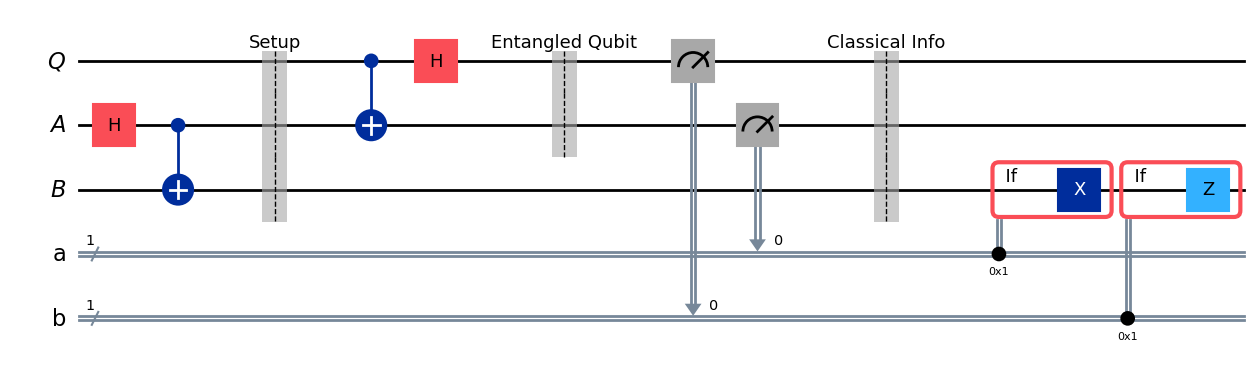

In [18]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Here we prep the ebit
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier(label="Setup")

# Alice's Operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier(0, 1, label="Entangled Qubit")

protocol.measure(qubit, b)
protocol.measure(ebit0, a)
protocol.barrier(label="Classical Info")

# Bob's Operations
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

protocol.draw("mpl")

We now want to create a random qubit, we'll do this by choosing a unitary qubit gate to parse a std. basis state into.

In [19]:
random_gate = UGate(
    theta = random.random() * 2 * pi,
    phi = random.random() * 2 * pi,
    lam = random.random() * 2 * pi,
)
display(random_gate.to_matrix())

array([[-0.57892839+0.j        ,  0.03751115-0.81451509j],
       [ 0.33985087-0.74117697j, -0.5145865 -0.26525236j]])

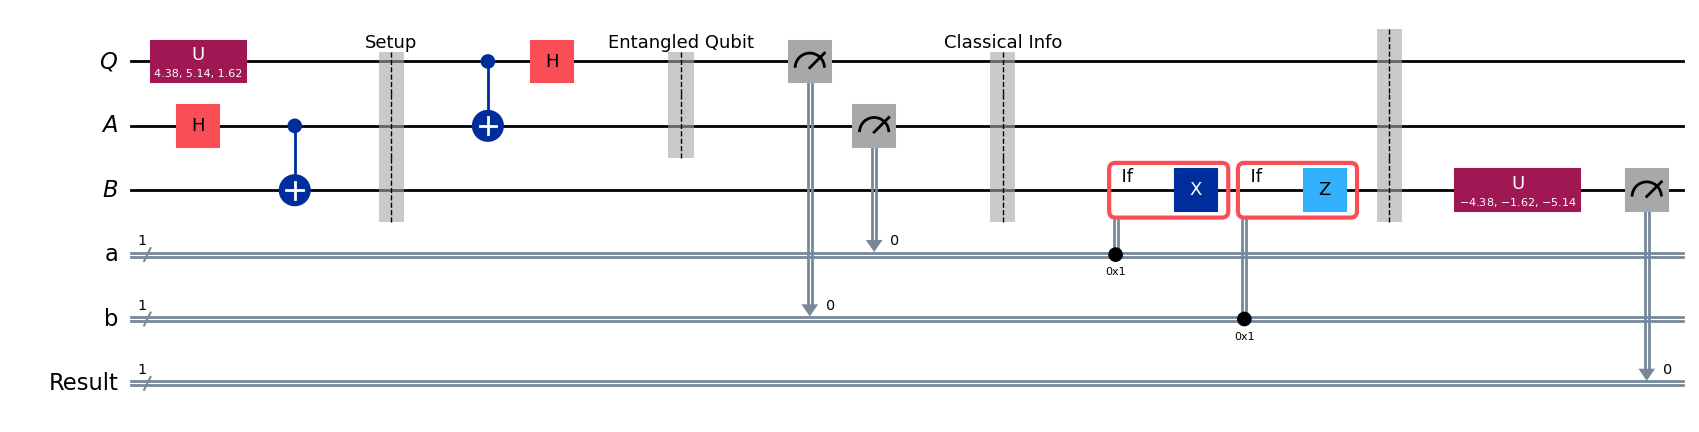

In [20]:
# Now we apply this unitary gate

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

test.append(random_gate, qubit)

test = test.compose(protocol)
test.barrier()

test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw("mpl"))

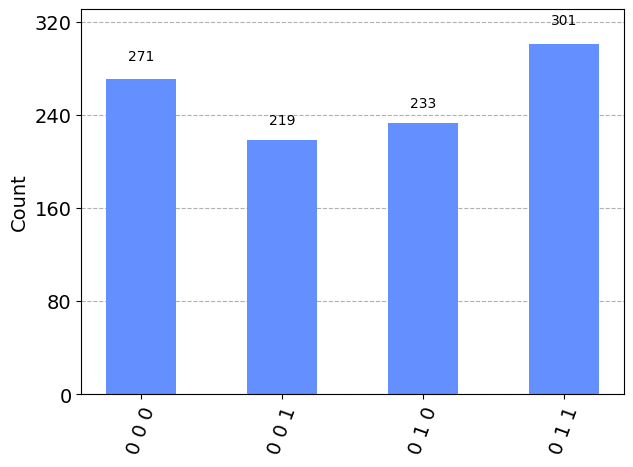

In [21]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
plot_histogram(statistics)

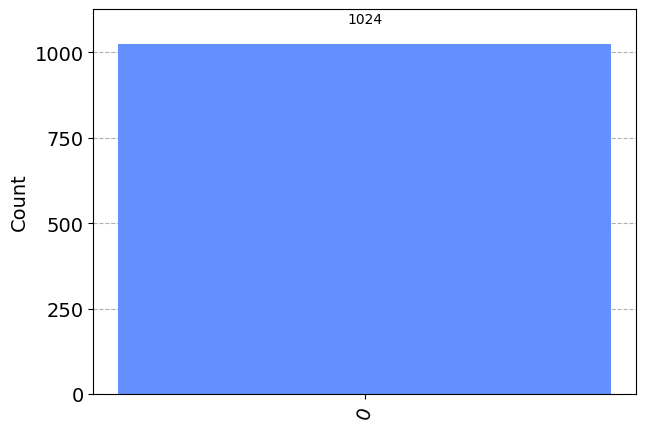

In [22]:
# Proof of concept: Filtering statistics to show the test result qubit
filt_stats = marginal_distribution(statistics, [2])
plot_histogram(filt_stats)

## Superdense Coding

In [15]:
c = "1"
d = "0"

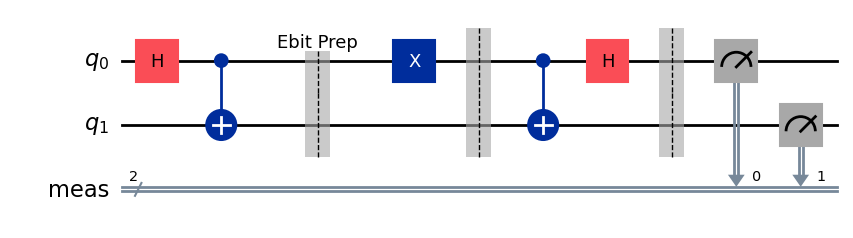

In [16]:
protocol = QuantumCircuit(2)

protocol.h(0)
protocol.cx(0, 1)
protocol.barrier(label="Ebit Prep")

# Alice's Operation
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

protocol.draw("mpl")

Measured 10 with frequency 1.0


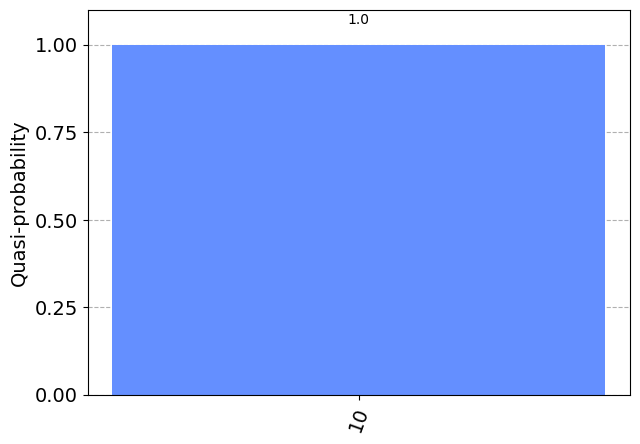

In [17]:
result = Sampler().run(protocol).result()
statistics = result.quasi_dists[0].binary_probabilities()

for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")

plot_histogram(statistics)

### Additional Fun Things

In [23]:
rbg = QuantumRegister(1, "randomiser")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

A_c = ClassicalRegister(1, "Alice c")
A_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, A_d, A_c)

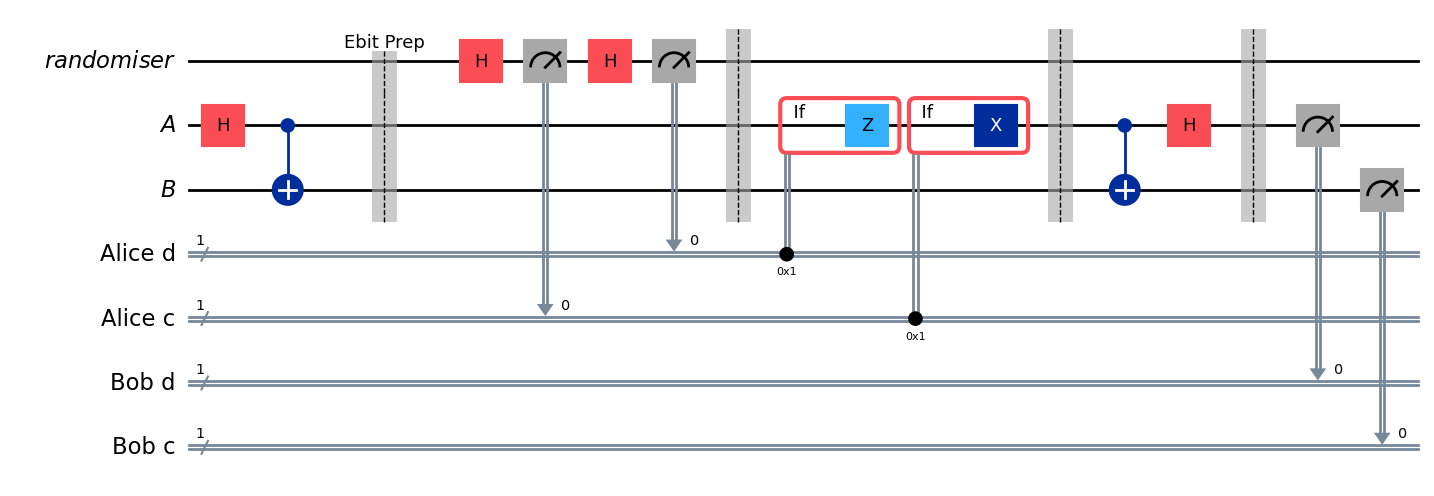

In [24]:
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier(label="Ebit Prep")

test.h(rbg)
test.measure(rbg, A_c)
test.h(rbg)
test.measure(rbg, A_d)
test.barrier()

# Alice's First Actions
with test.if_test((A_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((A_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's Actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

B_c = ClassicalRegister(1, "Bob c")
B_d = ClassicalRegister(1, "Bob d")
test.add_register(B_d)
test.add_register(B_c)
test.measure(ebit0, B_d)
test.measure(ebit1, B_c)

test.draw("mpl")

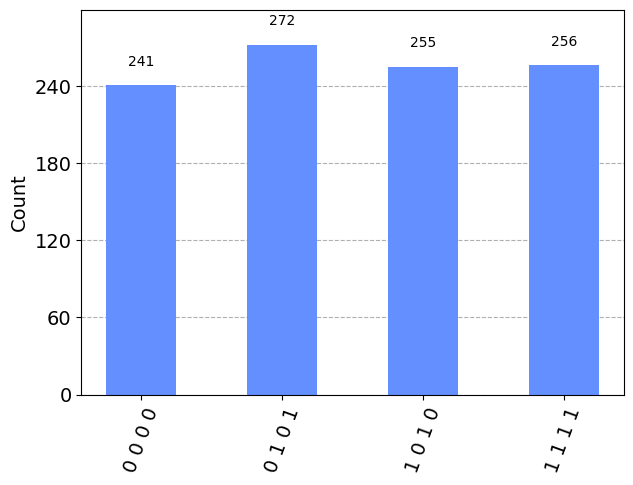

In [25]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
plot_histogram(statistics)

## CHSH Game

In [4]:
def chsh_game(strategy):
    # Referee chooses x and y rnadomly
    x, y = randint(0, 2), randint(0, 2)

    # User strategy to choose a and b
    a, b = strategy(x, y)

    # Referee decides if Alice and Bob win or lose
    if (a != b) == (x & y):
        return 1 # Win
    return 0 # Lose

In [5]:
def chsh_circuit(x, y):
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-pi /2, 0)
    qc.measure(0, 0)

    # Bob
    if y == 0:
        qc.ry(-pi / 4, 1)
    else:
        qc.ry(pi / 4, 1)
    qc.measure(1, 1)

    return qc

(x, y) = (0, 0)


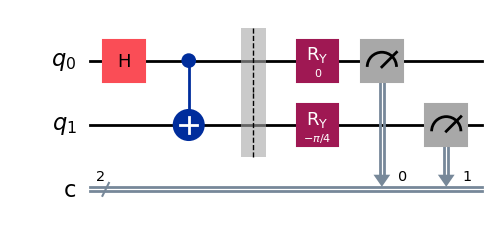

(x, y) = (0, 1)


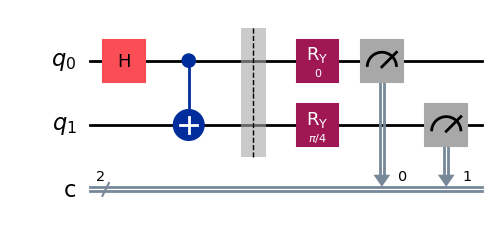

(x, y) = (1, 0)


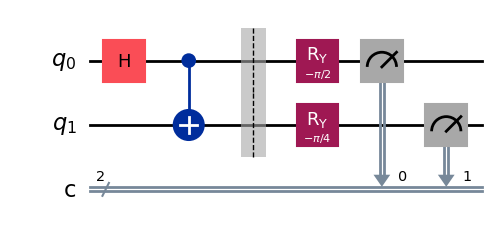

(x, y) = (1, 1)


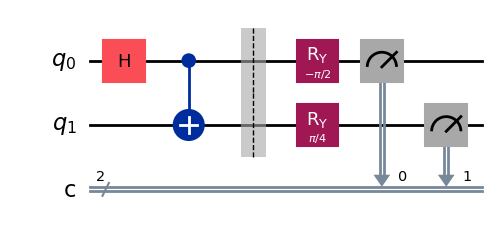

In [8]:
print("(x, y) = (0, 0)")
display(chsh_circuit(0, 0).draw("mpl"))

print("(x, y) = (0, 1)")
display(chsh_circuit(0, 1).draw("mpl"))

print("(x, y) = (1, 0)")
display(chsh_circuit(1, 0).draw("mpl"))

print("(x, y) = (1, 1)")
display(chsh_circuit(1, 1).draw("mpl"))

In [13]:
sampler = Sampler()

def quantum_strategy(x, y):
    result = sampler.run(chsh_circuit(x, y), shots=1).result()
    statistics = result.quasi_dists[0].binary_probabilities()
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]
    return a, b

In [14]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.86
